<a href="https://colab.research.google.com/github/Pas38/Machine_Learning/blob/main/esame_4.9/MetodiAIFisica_ApplicazioniFisicheML_2025_ProvaPratica_4_9_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prova Pratica - Metodi AI per la fisica e Applicazioni Fisiche al ML
### 4.9.2026 - AA 2024/25 - Docenti: S. Giagu e A. Ciardiello

---

**Regole:**

*   **tempo a disposizione:** 3.0h

*   compilare con i vostri dati i campi della cella che segue e poi eseguire la cella verificando che i dati printati corrispondano.
*   risolvere i quesiti/compiti indicati nella cella *Descrizione del compito*.
*   una volta completato il compito scaricare il notebook in formato *.ipynb* e caricarlo **usando il google form**:
[consegna notebook](https://docs.google.com/forms/d/e/1FAIpQLSclIxcSFvv9hGKDknClTXHi9hlY3lPgYlj3rGlN3a2UoZagjg/viewform?usp=sharing&ouid=116129231158107005144)<p>


**NOTA:** una volta caricato e sottomesso il notebook non sono più possibili ulteriori modifiche.

In [46]:
#@ Dati Personali
import os

Nome = 'Lorenzo'  #@param {type: "string"}
Cognome = 'Pasqualetti' #@param {type: "string"}
NumeroMatricola = 2084642 #@param {type: "number"}

if NumeroMatricola == 12345678:
  print('\033[1;31m Inserisci il numero di matricola corretto!!!!')
else:
  print('\033[1;31m Done')

 Done


# Descrizione del compito:

**Svolgere i seguenti quesiti:**

1. (Q1): progettare e allenare un modello basato su MLP, che prenda in input due numeri interi di due cifre [10, ..., 99] e predica le 4 cifre del risultato del prodotto dei due numeri.
2. (Q2): valutare le prestazioni del modello rispetto alle due seguenti metriche:

> *   accuracy esatta del risultato predetto dal modello (tutte le cifre corette)
> *   accuarcy a livello di digit (percentuale di singoli digit correttamente predetti dal modello).

3. (Q3) produrre una analisi delle prestazioni del modello al variare della profondità del MLP utilizzato: 1, 2, 3 e 4 layer.

4. (Q4) risolvere lo stesso problema usando una RandomForest (usando la libreria scikit-learn) con stesse feature e target, e confrontare le prestazioni con quelle ottenute dal modello Q1 e commentare i risultati.


* commentare opportunamente i risultati ottenuti in ogni punto.

In [47]:
#codice ...
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Seed fisso per riproducibilità
torch.manual_seed(42)
np.random.seed(42)


# Generazione dati


print("\n Q0: Generazione dati")

# Dataset: due numeri a due digit and il loro prodotto
def generate_dataset(n_samples=10000):
    np.random.seed(42)
    primo = np.random.randint(10, 100, n_samples)
    secondo = np.random.randint(10, 100, n_samples)
    prod = primo * secondo

    # Salva le 4 digit singolarmente (con lo 0 per le migliaia se necessario, zfill)
    digits = []
    for product in prod:
        product_str = str(product).zfill(4)
        digits.append([int(d) for d in product_str])

    return primo, secondo, np.array(digits)

# Generate dataset
n_samples = 10000
primo, secondo, prod_digits = generate_dataset(n_samples)

# Input features: concatena i due numeri
X = np.column_stack([primo, secondo])
y = prod_digits

print(f"Dataset shape: X={X.shape}, y={y.shape}")
print(f"Sample data: {primo[0]} * {secondo[0]} = {primo[0] * secondo[0]}")
print(f"Target digits: {y[0]}")

# Split train, validation, test (70%, 15%, 15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42  #Si adatta a qualunque n_samples
)

print(f"\n Splitting dati:")
print(f"Train: {X_train.shape[0]} samples")
print(f"Validation: {X_val.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")

# Normalizzazione
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train.astype(np.float32))
X_val_scaled = scaler_X.transform(X_val.astype(np.float32))
X_test_scaled = scaler_X.transform(X_test.astype(np.float32))

#PyTorch
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_val_tensor = torch.FloatTensor(X_val_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)

y_train_tensor = torch.LongTensor(y_train)
y_val_tensor = torch.LongTensor(y_val)
y_test_tensor = torch.LongTensor(y_test)

# DataLoaders
batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


 Q0: Generazione dati
Dataset shape: X=(10000, 2), y=(10000, 4)
Sample data: 61 * 77 = 4697
Target digits: [4 6 9 7]

 Splitting dati:
Train: 6999 samples
Validation: 1501 samples
Test: 1500 samples


In [48]:
# Q1: Definizione modello MLP


print("\n Q1: Modello MLP (codice)")


class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim=4):
        super(MLPModel, self).__init__()
        layers = []

        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.2))

        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))

        # Output layer (4 digits)
        layers.append(nn.Linear(hidden_dims[-1], output_dim * 10))

        self.network = nn.Sequential(*layers)
        self.output_dim = output_dim

    def forward(self, x):
        x = self.network(x)
        # Reshape (batch_size, 4 digits, 10 classes)
        x = x.view(-1, self.output_dim, 10)
        return x

# Training function
def train_mlp(model, train_loader, val_loader, num_epochs=100, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()

            outputs = model(batch_X)  # Shape: (batch_size, 4, 10)

            # Calcola loss
            loss = 0
            for digit_idx in range(4):
                loss += criterion(outputs[:, digit_idx, :], batch_y[:, digit_idx])

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = 0
                for digit_idx in range(4):
                    loss += criterion(outputs[:, digit_idx, :], batch_y[:, digit_idx])
                val_loss += loss.item()

        epoch_val_loss = val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)

        # Learning rate scheduling
        scheduler.step(epoch_val_loss)

        # Salva il modello migliore
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict().copy()

        if (epoch + 1) % 20 == 0: # Stampa come sta andando ogni 20 epochs
            print(f'Epoch [{epoch+1:3d}/{num_epochs}], '
                  f'Train Loss: {epoch_train_loss:.4f}, '
                  f'Val Loss: {epoch_val_loss:.4f}, '
                  f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

    # Restituisce il best model
    model.load_state_dict(best_model_state)
    return train_losses, val_losses

# Valutazione modello
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            outputs = model(batch_X)
            # Prende le digits predette
            preds = torch.argmax(outputs, dim=2)  # Shape: (batch_size, 4)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(batch_y.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)

    # Accuracy esatta (tutti i 4 digits corretti)
    exact_correct = np.all(all_preds == all_targets, axis=1)
    exact_accuracy = np.mean(exact_correct) * 100

    # Accuracy a livello di digit
    digit_accuracy = np.mean(all_preds == all_targets) * 100

    return exact_accuracy, digit_accuracy, all_preds, all_targets


 Q1: Modello MLP (codice)



 Q3: MLP con vari layers e analisi (1, 2, 3, 4 layers); l'analisi del modello (Q2) verrà svolta sul best model tra questi

 Training del 1_layer MLP...
Architecture: [64]
Epoch [ 20/100], Train Loss: 7.4132, Val Loss: 7.3513, LR: 0.001000
Epoch [ 40/100], Train Loss: 7.1956, Val Loss: 7.1411, LR: 0.001000
Epoch [ 60/100], Train Loss: 7.0947, Val Loss: 7.0417, LR: 0.001000
Epoch [ 80/100], Train Loss: 7.0364, Val Loss: 6.9900, LR: 0.001000
Epoch [100/100], Train Loss: 7.0030, Val Loss: 6.9516, LR: 0.001000
1_layer - Accuracy esatta: 0.07%, Accuracy a livello di digit: 35.82%

 Training del 2_layers MLP...
Architecture: [64, 32]
Epoch [ 20/100], Train Loss: 7.2409, Val Loss: 7.0741, LR: 0.001000
Epoch [ 40/100], Train Loss: 7.0963, Val Loss: 6.9327, LR: 0.001000
Epoch [ 60/100], Train Loss: 7.0278, Val Loss: 6.8783, LR: 0.001000
Epoch [ 80/100], Train Loss: 6.9756, Val Loss: 6.8408, LR: 0.001000
Epoch [100/100], Train Loss: 6.9554, Val Loss: 6.8097, LR: 0.001000
2_layers - Accuracy esat

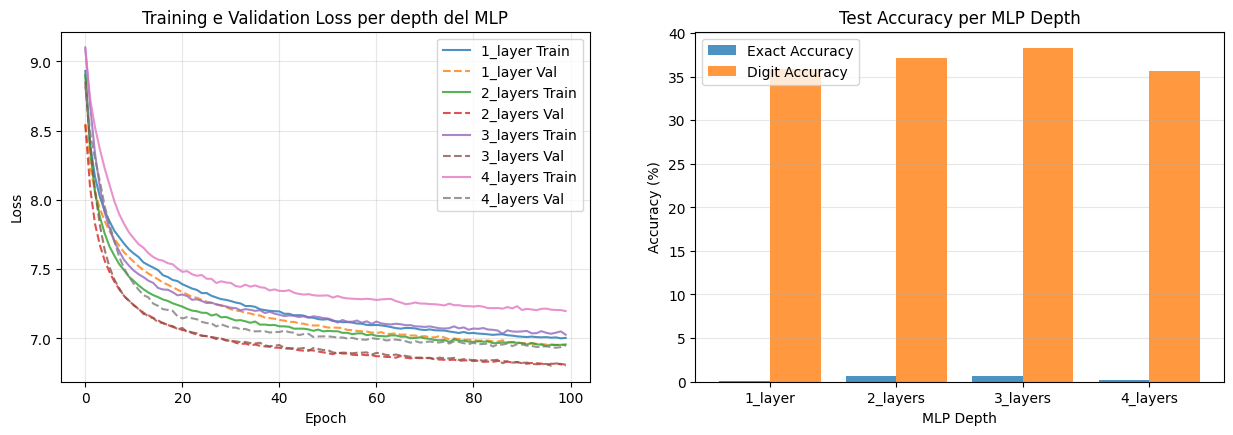

In [49]:
# Q3: MLP da 1 a 4 layer (l'analisi del modello sarà fatta sul best model)


print("\n Q3: MLP con vari layers e analisi (1, 2, 3, 4 layers); l'analisi del modello (Q2) verrà svolta sul best model tra questi")


# Define different architectures
architectures = {
    '1_layer': [64],
    '2_layers': [64, 32],
    '3_layers': [64, 32, 16],
    '4_layers': [64, 32, 16, 8]
}

results = {}

for depth_name, hidden_dims in architectures.items():
    print(f"\n Training del {depth_name} MLP...")
    print(f"Architecture: {hidden_dims}")

    model = MLPModel(input_dim=2, hidden_dims=hidden_dims)
    train_losses, val_losses = train_mlp(model, train_loader, val_loader, num_epochs=100)

    # Valutazione sul test
    exact_acc, digit_acc, _, _ = evaluate_model(model, test_loader)
    results[depth_name] = {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'exact_accuracy': exact_acc,
        'digit_accuracy': digit_acc
    }

    print(f"{depth_name} - Accuracy esatta: {exact_acc:.2f}%, Accuracy a livello di digit: {digit_acc:.2f}%")

# Plot training curves
plt.figure(figsize=(15, 10))

# Curve loss
for i, (depth_name, result) in enumerate(results.items()):
    plt.subplot(2, 2, 1)
    plt.plot(result['train_losses'], label=f'{depth_name} Train', alpha=0.8)
    plt.plot(result['val_losses'], label=f'{depth_name} Val', linestyle='--', alpha=0.8)

plt.subplot(2, 2, 1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training e Validation Loss per depth del MLP')
plt.legend()
plt.grid(True, alpha=0.3)

# COnfronto Accuracy
depths = list(results.keys())
exact_accs = [results[d]['exact_accuracy'] for d in depths]
digit_accs = [results[d]['digit_accuracy'] for d in depths]

plt.subplot(2, 2, 2)
x_pos = np.arange(len(depths))
plt.bar(x_pos - 0.2, exact_accs, 0.4, label='Exact Accuracy', alpha=0.8)
plt.bar(x_pos + 0.2, digit_accs, 0.4, label='Digit Accuracy', alpha=0.8)
plt.xlabel('MLP Depth')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy per MLP Depth')
plt.xticks(x_pos, depths)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Scelta best_depth
best_depth = max(results.items(), key=lambda x: x[1]['exact_accuracy'])[0]
best_model = results[best_depth]['model']
print(f"\n Best model: {best_depth}")


 Q2: Valutazione performance del Best MLP Model
Best Model (3_layers) Performance:
Accuracy esatta (tutti i 4 digits corretti): 0.67%
Accuracy a livello di digit: 38.25%


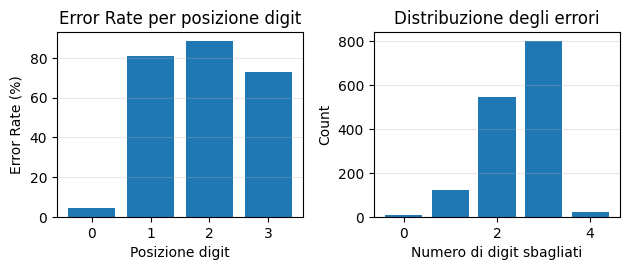

In [50]:
# Q2: Valutazione delle performance del modello (fatta sul best_model)


print("\n Q2: Valutazione performance del Best MLP Model")


# Evaluate best model on test set
exact_acc, digit_acc, all_preds, all_targets = evaluate_model(best_model, test_loader)

print(f"Best Model ({best_depth}) Performance:")
print(f"Accuracy esatta (tutti i 4 digits corretti): {exact_acc:.2f}%")
print(f"Accuracy a livello di digit: {digit_acc:.2f}%")

# Analyze error patterns
errors_by_position = []
for digit_idx in range(4):
    correct = np.mean(all_preds[:, digit_idx] == all_targets[:, digit_idx])
    errors_by_position.append(100 * (1 - correct))

plt.subplot(2, 2, 3)
plt.bar(range(4), errors_by_position)
plt.xlabel('Posizione digit')
plt.ylabel('Error Rate (%)')
plt.title('Error Rate per posizione digit')
plt.grid(True, alpha=0.3, axis='y')

# Error distribution
error_counts = []
for i in range(5):
    error_counts.append(np.sum(np.sum(all_preds != all_targets, axis=1) == i))

plt.subplot(2, 2, 4)
plt.bar(range(5), error_counts)
plt.xlabel('Numero di digit sbagliati')
plt.ylabel('Count')
plt.title('Distribuzione degli errori')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('mlp_analysis.png', dpi=300, bbox_inches='tight')
plt.show()



 Q4: Confronto con Random Forest
Training Random Forest...
Random Forest Performance:
Accuracy esatta (tutti i 4 digits corretti): 1.80%
Accuracy a livello di digit: 37.58%

 CONFRONTO FINALE

 Confronto modelli:
Diversi MLP:
  1_layer: Esatta=0.07%, Acc digit=35.82%
  2_layers: Esatta=0.60%, Acc digit=37.10%
  3_layers: Esatta=0.67%, Acc digit=38.25%
  4_layers: Esatta=0.20%, Acc digit=35.68%
Random Forest: Acc esatta=1.80%, Acc digit=37.58%


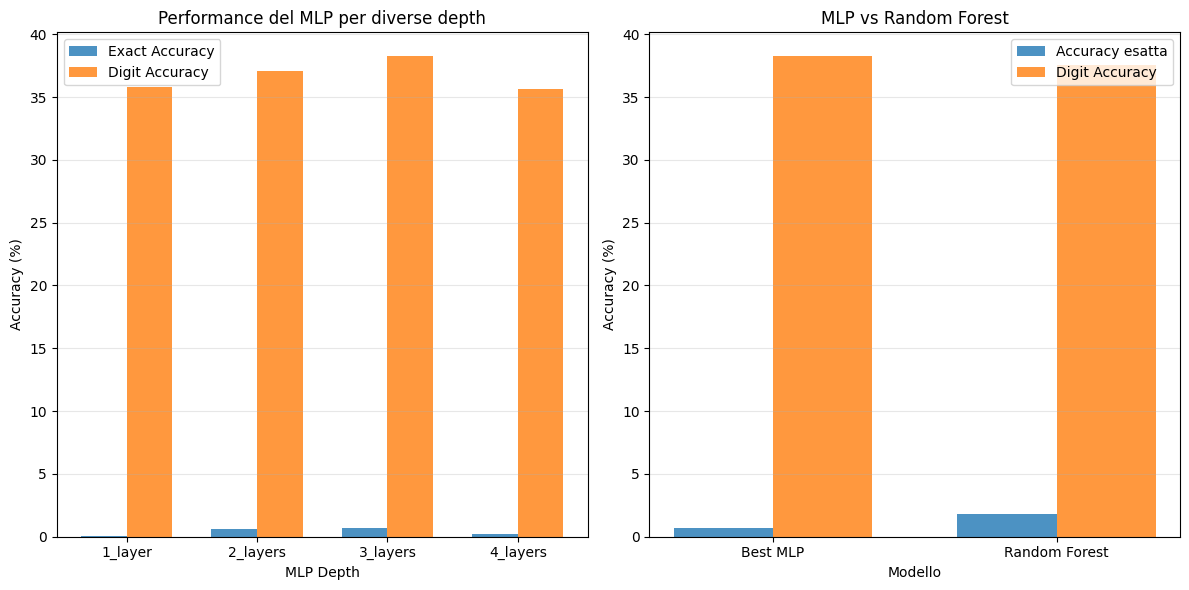

In [51]:
# Q4: Confronto Random Forest


print("\n Q4: Confronto con Random Forest")


# Preparazione dati Random Forest
y_train_flat = y_train.reshape(-1, 4)
y_val_flat = y_val.reshape(-1, 4)
y_test_flat = y_test.reshape(-1, 4)

# Train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest...")
rf_model.fit(X_train_scaled, y_train_flat)

# Predizione e arrotondamento al digit più vicino (0-9)
rf_preds = rf_model.predict(X_test_scaled)
rf_preds_digits = np.round(rf_preds).astype(int)
rf_preds_digits = np.clip(rf_preds_digits, 0, 9)  #Si assicura che i digit siano da 0 a 9

# Calcolo Accuracies
rf_exact_correct = np.all(rf_preds_digits == y_test_flat, axis=1)
rf_exact_accuracy = np.mean(rf_exact_correct) * 100
rf_digit_accuracy = np.mean(rf_preds_digits == y_test_flat) * 100

print(f"Random Forest Performance:")
print(f"Accuracy esatta (tutti i 4 digits corretti): {rf_exact_accuracy:.2f}%")
print(f"Accuracy a livello di digit: {rf_digit_accuracy:.2f}%")


#Confronto


print("\n CONFRONTO FINALE")


# Compare all models
mlp_exact_accs = [results[d]['exact_accuracy'] for d in architectures.keys()]
mlp_digit_accs = [results[d]['digit_accuracy'] for d in architectures.keys()]

print("\n Confronto modelli:")
print("Diversi MLP:")
for depth_name in architectures.keys():
    print(f"  {depth_name}: Esatta={results[depth_name]['exact_accuracy']:.2f}%, "
          f"Acc digit={results[depth_name]['digit_accuracy']:.2f}%")

print(f"Random Forest: Acc esatta={rf_exact_accuracy:.2f}%, Acc digit={rf_digit_accuracy:.2f}%")

# Plot confronto
plt.figure(figsize=(12, 6))

# COnfronto depth MLP
plt.subplot(1, 2, 1)
x_pos = np.arange(len(architectures))
width = 0.35
plt.bar(x_pos - width/2, mlp_exact_accs, width, label='Exact Accuracy', alpha=0.8)
plt.bar(x_pos + width/2, mlp_digit_accs, width, label='Digit Accuracy', alpha=0.8)
plt.xlabel('MLP Depth')
plt.ylabel('Accuracy (%)')
plt.title('Performance del MLP per diverse depth')
plt.xticks(x_pos, list(architectures.keys()))
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Confronto MLP e RandomForest
plt.subplot(1, 2, 2)
models = ['Best MLP', 'Random Forest']
exact_accs_compare = [results[best_depth]['exact_accuracy'], rf_exact_accuracy]
digit_accs_compare = [results[best_depth]['digit_accuracy'], rf_digit_accuracy]

x_pos = np.arange(len(models))
plt.bar(x_pos - width/2, exact_accs_compare, width, label='Accuracy esatta', alpha=0.8)
plt.bar(x_pos + width/2, digit_accs_compare, width, label='Digit Accuracy', alpha=0.8)
plt.xlabel('Modello')
plt.ylabel('Accuracy (%)')
plt.title('MLP vs Random Forest')
plt.xticks(x_pos, models)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('final_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [52]:
# Discussione risultati



print("\n Discussione risultati")


print("\n Q1&Q2: Performance del modello MLP")
print("- Il MLP fa fatica a predire correttamente i risultati, soprattutto l'accuracy esatta; si comporta invece meglio per quanto riguarda l'accuracy a livello di digit, poiché predire correttamente tutte le 4 cifre è più complesso")
print("- Da un'analisi sull'errore della posizione dei digit, si ha che il digit corrispondente alle unità viene sbagliato significativamente meno rispetto agli altri: il motivo potrebbe essere che le unità non devono tenere conto di eventuali riporti nel corso della moltiplicazione, come invece si deve fare per gli altri digit")

print("\n Q3: Analisi profondità MLP")
print("- Aumentare i layer migliora le prestazioni fino al terzo, dopo il quale si ha un calo delle prestazioni (è di conseguenza inutile fare prove per modelli con più di 4 layer)")
print("- Il motivo è che modelli con troppi layer possono facilmente fare overfitting per task di questo tipo")
print("- Tutti i modelli convergono, a prescindere dal numero di layer, come si può vedere dal grafico")

print("\n Q4: Confronto con Random Forest")
print("- La Random Forest performa meglio del MLP per quanto riguarda l'accuracy esatta, e sostanzialmente allo stesso modo per l'accuracy a livello di digit")
print("- Questo è dovuto al fatto che il target è discreto, con sole due feature di input: in task semplici di questo tipo la Random Forest, meno sensibile di un NN agli iperparametri e necessitante di meno tuning, si comporta meglio")

print("\n Extra: Con un numero di samples di 30k si era raggiunta una Accuracy esatta dell'1.16%, un miglioramento marginale al caso (consegnato) da 10k, che non giustifica il costo.")
print("- Era tuttavia interessante notare l'overfitting del modello MLP a 4 layer, che con 30k samples ha performato peggio rispetto al caso con 10k.")


 Discussione risultati

 Q1&Q2: Performance del modello MLP
- Il MLP fa fatica a predire correttamente i risultati, soprattutto l'accuracy esatta; si comporta invece meglio per quanto riguarda l'accuracy a livello di digit, poiché predire correttamente tutte le 4 cifre è più complesso
- Da un'analisi sull'errore della posizione dei digit, si ha che il digit corrispondente alle unità viene sbagliato significativamente meno rispetto agli altri: il motivo potrebbe essere che le unità non devono tenere conto di eventuali riporti nel corso della moltiplicazione, come invece si deve fare per gli altri digit

 Q3: Analisi profondità MLP
- Aumentare i layer migliora le prestazioni fino al terzo, dopo il quale si ha un calo delle prestazioni (è di conseguenza inutile fare prove per modelli con più di 4 layer)
- Il motivo è che modelli con troppi layer possono facilmente fare overfitting per task di questo tipo
- Tutti i modelli convergono, a prescindere dal numero di layer, come si può vedere 